In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(0)   
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[79259:92469] 
Y_train_SS = Y_train_SS[79259:92469]
Y_train_V = Y_train_V[79259:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 13210
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 13210 samples, validate on 13210 samples
Epoch 1/100
13120/13210 [============================>.] - ETA: 0s - loss: 0.0775 - dense_5_loss: 0.0631 - dense_6_loss: 0.0144 - dense_5_mse: 0.0631 - dense_6_mse: 0.0144

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.04027, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 5s 341us/sample - loss: 0.0772 - dense_5_loss: 0.0627 - dense_6_loss: 0.0145 - dense_5_mse: 0.0627 - dense_6_mse: 0.0145 - val_loss: 0.0403 - val_dense_5_loss: 0.0230 - val_dense_6_loss: 0.0173 - val_dense_5_mse: 0.0230 - val_dense_6_mse: 0.0173
Epoch 2/100
12544/13210 [===========================>..] - ETA: 0s - loss: 0.0250 - dense_5_loss: 0.0108 - dense_6_loss: 0.0142 - dense_5_mse: 0.0108 - dense_6_mse: 0.0142
Epoch 2: val_loss improved from 0.04027 to 0.03290, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 197us/sample - loss: 0.0249 - dense_5_loss: 0.0106 - dense_6_loss: 0.0143 - dense_5_mse: 0.0106 - dense_6_mse: 0.0143 - val_loss: 0.0329 - val_dense_5_loss: 0.0159 - val_dense_6_loss: 0.0170 - val_dense_5_mse: 0.0159 - val_dense_6_mse: 0.0170
Epoch 3/100
12896/13210 [============================>.] - ETA: 0s - loss: 0.0210 - dense_5_loss: 0.0065 - dense_6_loss: 0.0145 - dense_5_mse: 0.0065 - dense_6_mse: 0.0145
Epoch 3: val_loss improved from 0.03290 to 0.02841, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 195us/sample - loss: 0.0208 - dense_5_loss: 0.0065 - dense_6_loss: 0.0143 - dense_5_mse: 0.0065 - dense_6_mse: 0.0143 - val_loss: 0.0284 - val_dense_5_loss: 0.0112 - val_dense_6_loss: 0.0172 - val_dense_5_mse: 0.0112 - val_dense_6_mse: 0.0172
Epoch 4/100
12864/13210 [============================>.] - ETA: 0s - loss: 0.0196 - dense_5_loss: 0.0053 - dense_6_loss: 0.0142 - dense_5_mse: 0.0053 - dense_6_mse: 0.0142
Epoch 4: val_loss improved from 0.02841 to 0.02693, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 4s 318us/sample - loss: 0.0196 - dense_5_loss: 0.0053 - dense_6_loss: 0.0143 - dense_5_mse: 0.0053 - dense_6_mse: 0.0143 - val_loss: 0.0269 - val_dense_5_loss: 0.0100 - val_dense_6_loss: 0.0169 - val_dense_5_mse: 0.0100 - val_dense_6_mse: 0.0169
Epoch 5/100
13152/13210 [============================>.] - ETA: 0s - loss: 0.0184 - dense_5_loss: 0.0043 - dense_6_loss: 0.0142 - dense_5_mse: 0.0043 - dense_6_mse: 0.0142
Epoch 5: val_loss did not improve from 0.02693
13210/13210 [==============================] - 1s 102us/sample - loss: 0.0185 - dense_5_loss: 0.0043 - dense_6_loss: 0.0142 - dense_5_mse: 0.0043 - dense_6_mse: 0.0142 - val_loss: 0.0300 - val_dense_5_loss: 0.0131 - val_dense_6_loss: 0.0169 - val_dense_5_mse: 0.0131 - val_dense_6_mse: 0.0169
Epoch 6/100
12736/13210 [===========================>..] - ETA: 0s - loss: 0.0175 - dense_5_loss: 0.0035 - dense_6_loss: 0.0140 - dense_5_mse: 0.0035 - dense_6_mse: 0.0140
Epoch 6: val_loss impro

13210/13210 [==============================] - 3s 210us/sample - loss: 0.0176 - dense_5_loss: 0.0035 - dense_6_loss: 0.0141 - dense_5_mse: 0.0035 - dense_6_mse: 0.0141 - val_loss: 0.0219 - val_dense_5_loss: 0.0053 - val_dense_6_loss: 0.0167 - val_dense_5_mse: 0.0053 - val_dense_6_mse: 0.0167
Epoch 7/100
12832/13210 [============================>.] - ETA: 0s - loss: 0.0156 - dense_5_loss: 0.0029 - dense_6_loss: 0.0127 - dense_5_mse: 0.0029 - dense_6_mse: 0.0127
Epoch 7: val_loss improved from 0.02194 to 0.02093, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 199us/sample - loss: 0.0156 - dense_5_loss: 0.0029 - dense_6_loss: 0.0127 - dense_5_mse: 0.0029 - dense_6_mse: 0.0127 - val_loss: 0.0209 - val_dense_5_loss: 0.0068 - val_dense_6_loss: 0.0141 - val_dense_5_mse: 0.0068 - val_dense_6_mse: 0.0141
Epoch 8/100
12512/13210 [===========================>..] - ETA: 0s - loss: 0.0124 - dense_5_loss: 0.0040 - dense_6_loss: 0.0085 - dense_5_mse: 0.0040 - dense_6_mse: 0.0085
Epoch 8: val_loss improved from 0.02093 to 0.00898, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 200us/sample - loss: 0.0122 - dense_5_loss: 0.0039 - dense_6_loss: 0.0083 - dense_5_mse: 0.0039 - dense_6_mse: 0.0083 - val_loss: 0.0090 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 0.0058 - val_dense_5_mse: 0.0032 - val_dense_6_mse: 0.0058
Epoch 9/100
13120/13210 [============================>.] - ETA: 0s - loss: 0.0099 - dense_5_loss: 0.0034 - dense_6_loss: 0.0065 - dense_5_mse: 0.0034 - dense_6_mse: 0.0065
Epoch 9: val_loss improved from 0.00898 to 0.00795, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 199us/sample - loss: 0.0099 - dense_5_loss: 0.0034 - dense_6_loss: 0.0064 - dense_5_mse: 0.0034 - dense_6_mse: 0.0064 - val_loss: 0.0080 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 0.0045 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 0.0045
Epoch 10/100
12992/13210 [============================>.] - ETA: 0s - loss: 0.0087 - dense_5_loss: 0.0030 - dense_6_loss: 0.0057 - dense_5_mse: 0.0030 - dense_6_mse: 0.0057
Epoch 10: val_loss improved from 0.00795 to 0.00782, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 197us/sample - loss: 0.0086 - dense_5_loss: 0.0030 - dense_6_loss: 0.0056 - dense_5_mse: 0.0030 - dense_6_mse: 0.0056 - val_loss: 0.0078 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0043 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0043
Epoch 11/100
12704/13210 [===========================>..] - ETA: 0s - loss: 0.0062 - dense_5_loss: 0.0024 - dense_6_loss: 0.0038 - dense_5_mse: 0.0024 - dense_6_mse: 0.0038
Epoch 11: val_loss improved from 0.00782 to 0.00715, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 210us/sample - loss: 0.0062 - dense_5_loss: 0.0024 - dense_6_loss: 0.0037 - dense_5_mse: 0.0024 - dense_6_mse: 0.0037 - val_loss: 0.0072 - val_dense_5_loss: 0.0038 - val_dense_6_loss: 0.0033 - val_dense_5_mse: 0.0038 - val_dense_6_mse: 0.0033
Epoch 12/100
12544/13210 [===========================>..] - ETA: 0s - loss: 0.0059 - dense_5_loss: 0.0023 - dense_6_loss: 0.0035 - dense_5_mse: 0.0023 - dense_6_mse: 0.0035
Epoch 12: val_loss did not improve from 0.00715
13210/13210 [==============================] - 1s 96us/sample - loss: 0.0058 - dense_5_loss: 0.0023 - dense_6_loss: 0.0035 - dense_5_mse: 0.0023 - dense_6_mse: 0.0035 - val_loss: 0.0101 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 0.0069 - val_dense_5_mse: 0.0032 - val_dense_6_mse: 0.0069
Epoch 13/100
12736/13210 [===========================>..] - ETA: 0s - loss: 0.0050 - dense_5_loss: 0.0022 - dense_6_loss: 0.0028 - dense_5_mse: 0.0022 - dense_6_mse: 0.0028
Epoch 13: val_loss im

13210/13210 [==============================] - 3s 194us/sample - loss: 0.0049 - dense_5_loss: 0.0022 - dense_6_loss: 0.0028 - dense_5_mse: 0.0022 - dense_6_mse: 0.0028 - val_loss: 0.0067 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0041 - val_dense_6_mse: 0.0026
Epoch 14/100
12960/13210 [============================>.] - ETA: 0s - loss: 0.0051 - dense_5_loss: 0.0022 - dense_6_loss: 0.0029 - dense_5_mse: 0.0022 - dense_6_mse: 0.0029
Epoch 14: val_loss improved from 0.00669 to 0.00585, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 192us/sample - loss: 0.0051 - dense_5_loss: 0.0022 - dense_6_loss: 0.0029 - dense_5_mse: 0.0022 - dense_6_mse: 0.0029 - val_loss: 0.0059 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0032 - val_dense_6_mse: 0.0027
Epoch 15/100
12992/13210 [============================>.] - ETA: 0s - loss: 0.0042 - dense_5_loss: 0.0019 - dense_6_loss: 0.0023 - dense_5_mse: 0.0019 - dense_6_mse: 0.0023
Epoch 15: val_loss did not improve from 0.00585
13210/13210 [==============================] - 1s 98us/sample - loss: 0.0042 - dense_5_loss: 0.0019 - dense_6_loss: 0.0023 - dense_5_mse: 0.0019 - dense_6_mse: 0.0023 - val_loss: 0.0073 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0039 - val_dense_6_mse: 0.0034
Epoch 16/100
12704/13210 [===========================>..] - ETA: 0s - loss: 0.0035 - dense_5_loss: 0.0016 - dense_6_loss: 0.0018 - dense_5_mse: 0.0016 - dense_6_mse: 0.0018
Epoch 16: val_loss im

13210/13210 [==============================] - 3s 194us/sample - loss: 0.0035 - dense_5_loss: 0.0016 - dense_6_loss: 0.0018 - dense_5_mse: 0.0016 - dense_6_mse: 0.0018 - val_loss: 0.0036 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0017
Epoch 17/100
12800/13210 [============================>.] - ETA: 0s - loss: 0.0044 - dense_5_loss: 0.0020 - dense_6_loss: 0.0024 - dense_5_mse: 0.0020 - dense_6_mse: 0.0024
Epoch 17: val_loss did not improve from 0.00361
13210/13210 [==============================] - 1s 99us/sample - loss: 0.0045 - dense_5_loss: 0.0020 - dense_6_loss: 0.0025 - dense_5_mse: 0.0020 - dense_6_mse: 0.0025 - val_loss: 0.0112 - val_dense_5_loss: 0.0055 - val_dense_6_loss: 0.0058 - val_dense_5_mse: 0.0055 - val_dense_6_mse: 0.0058
Epoch 18/100
12704/13210 [===========================>..] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0018 - dense_6_loss: 0.0020 - dense_5_mse: 0.0018 - dense_6_mse: 0.0020
Epoch 18: val_loss di

13210/13210 [==============================] - 3s 193us/sample - loss: 0.0028 - dense_5_loss: 0.0013 - dense_6_loss: 0.0014 - dense_5_mse: 0.0013 - dense_6_mse: 0.0014 - val_loss: 0.0036 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0014
Epoch 28/100
13120/13210 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0014 - dense_6_loss: 0.0014 - dense_5_mse: 0.0014 - dense_6_mse: 0.0014
Epoch 28: val_loss did not improve from 0.00360
13210/13210 [==============================] - 1s 98us/sample - loss: 0.0028 - dense_5_loss: 0.0014 - dense_6_loss: 0.0014 - dense_5_mse: 0.0014 - dense_6_mse: 0.0014 - val_loss: 0.0037 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0019
Epoch 29/100
12640/13210 [===========================>..] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0013 - dense_6_loss: 0.0015 - dense_5_mse: 0.0013 - dense_6_mse: 0.0015
Epoch 29: val_loss di

13210/13210 [==============================] - 3s 209us/sample - loss: 0.0023 - dense_5_loss: 0.0011 - dense_6_loss: 0.0011 - dense_5_mse: 0.0011 - dense_6_mse: 0.0011 - val_loss: 0.0032 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0018
Epoch 34/100
12480/13210 [===========================>..] - ETA: 0s - loss: 0.0022 - dense_5_loss: 0.0011 - dense_6_loss: 0.0011 - dense_5_mse: 0.0011 - dense_6_mse: 0.0011
Epoch 34: val_loss did not improve from 0.00320
13210/13210 [==============================] - 1s 101us/sample - loss: 0.0022 - dense_5_loss: 0.0011 - dense_6_loss: 0.0011 - dense_5_mse: 0.0011 - dense_6_mse: 0.0011 - val_loss: 0.0046 - val_dense_5_loss: 0.0024 - val_dense_6_loss: 0.0022 - val_dense_5_mse: 0.0024 - val_dense_6_mse: 0.0022
Epoch 35/100
12672/13210 [===========================>..] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0012 - dense_6_loss: 0.0014 - dense_5_mse: 0.0012 - dense_6_mse: 0.0014
Epoch 35: val_loss d

13210/13210 [==============================] - 4s 303us/sample - loss: 0.0017 - dense_5_loss: 7.9820e-04 - dense_6_loss: 8.6120e-04 - dense_5_mse: 7.9823e-04 - dense_6_mse: 8.6159e-04 - val_loss: 0.0032 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0017
Epoch 47/100
12544/13210 [===========================>..] - ETA: 0s - loss: 0.0022 - dense_5_loss: 0.0010 - dense_6_loss: 0.0011 - dense_5_mse: 0.0010 - dense_6_mse: 0.0011
Epoch 47: val_loss did not improve from 0.00315
13210/13210 [==============================] - 1s 101us/sample - loss: 0.0022 - dense_5_loss: 0.0010 - dense_6_loss: 0.0012 - dense_5_mse: 0.0010 - dense_6_mse: 0.0012 - val_loss: 0.0039 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0021
Epoch 48/100
12768/13210 [===========================>..] - ETA: 0s - loss: 0.0021 - dense_5_loss: 9.7389e-04 - dense_6_loss: 0.0011 - dense_5_mse: 9.7389e-04 - dense_6_mse: 0.0

13210/13210 [==============================] - 3s 196us/sample - loss: 0.0020 - dense_5_loss: 9.5823e-04 - dense_6_loss: 0.0011 - dense_5_mse: 9.5829e-04 - dense_6_mse: 0.0011 - val_loss: 0.0029 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0016
Epoch 49/100
12832/13210 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 9.5982e-04 - dense_6_loss: 9.0556e-04 - dense_5_mse: 9.5982e-04 - dense_6_mse: 9.0556e-04
Epoch 49: val_loss did not improve from 0.00292
13210/13210 [==============================] - 1s 100us/sample - loss: 0.0019 - dense_5_loss: 0.0010 - dense_6_loss: 9.1085e-04 - dense_5_mse: 0.0010 - dense_6_mse: 9.1125e-04 - val_loss: 0.0048 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0024
Epoch 50/100
13024/13210 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0011 - dense_6_loss: 0.0013 - dense_5_mse: 0.0011 - dense_6_

13210/13210 [==============================] - 3s 201us/sample - loss: 0.0016 - dense_5_loss: 7.5177e-04 - dense_6_loss: 8.1433e-04 - dense_5_mse: 7.5169e-04 - dense_6_mse: 8.1469e-04 - val_loss: 0.0027 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0012
Epoch 66/100
12704/13210 [===========================>..] - ETA: 0s - loss: 0.0017 - dense_5_loss: 7.5693e-04 - dense_6_loss: 8.9523e-04 - dense_5_mse: 7.5693e-04 - dense_6_mse: 8.9523e-04
Epoch 66: val_loss did not improve from 0.00269
13210/13210 [==============================] - 1s 99us/sample - loss: 0.0017 - dense_5_loss: 7.8149e-04 - dense_6_loss: 9.1469e-04 - dense_5_mse: 7.8120e-04 - dense_6_mse: 9.1486e-04 - val_loss: 0.0038 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0020
Epoch 67/100
13184/13210 [============================>.] - ETA: 0s - loss: 0.0016 - dense_5_loss: 7.7776e-04 - dense_6_loss: 7.8742e-04 - dense_5

13210/13210 [==============================] - 3s 218us/sample - loss: 0.0019 - dense_5_loss: 8.4389e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.4384e-04 - dense_6_mse: 0.0011 - val_loss: 0.0026 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0012
Epoch 77/100
12640/13210 [===========================>..] - ETA: 0s - loss: 0.0013 - dense_5_loss: 6.3898e-04 - dense_6_loss: 6.9564e-04 - dense_5_mse: 6.3898e-04 - dense_6_mse: 6.9564e-04
Epoch 77: val_loss did not improve from 0.00260
13210/13210 [==============================] - 1s 101us/sample - loss: 0.0013 - dense_5_loss: 6.3620e-04 - dense_6_loss: 6.9755e-04 - dense_5_mse: 6.3633e-04 - dense_6_mse: 6.9768e-04 - val_loss: 0.0028 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0013
Epoch 78/100
13024/13210 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 6.3508e-04 - dense_6_loss: 8.1558e-04 - dense_5_mse: 6

13210/13210 [==============================] - 3s 197us/sample - loss: 0.0017 - dense_5_loss: 6.8435e-04 - dense_6_loss: 0.0011 - dense_5_mse: 6.8450e-04 - dense_6_mse: 0.0011 - val_loss: 0.0026 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0011
Epoch 97/100
12704/13210 [===========================>..] - ETA: 0s - loss: 0.0014 - dense_5_loss: 5.8318e-04 - dense_6_loss: 8.4384e-04 - dense_5_mse: 5.8318e-04 - dense_6_mse: 8.4384e-04
Epoch 97: val_loss improved from 0.00258 to 0.00235, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 3s 198us/sample - loss: 0.0015 - dense_5_loss: 5.8915e-04 - dense_6_loss: 8.9282e-04 - dense_5_mse: 5.8927e-04 - dense_6_mse: 8.9315e-04 - val_loss: 0.0024 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0011
Epoch 98/100
12576/13210 [===========================>..] - ETA: 0s - loss: 0.0015 - dense_5_loss: 6.3270e-04 - dense_6_loss: 8.2181e-04 - dense_5_mse: 6.3270e-04 - dense_6_mse: 8.2181e-04
Epoch 98: val_loss did not improve from 0.00235
13210/13210 [==============================] - 1s 101us/sample - loss: 0.0014 - dense_5_loss: 6.2339e-04 - dense_6_loss: 8.0981e-04 - dense_5_mse: 6.2355e-04 - dense_6_mse: 8.1017e-04 - val_loss: 0.0024 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0010
Epoch 99/100
12768/13210 [===========================>..] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.4624e-04 - dense_6_loss: 0.0011 - dense_5_ms

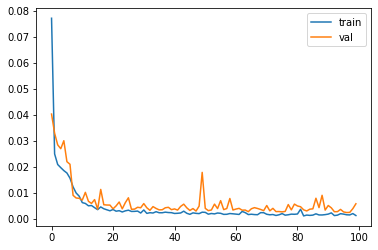

---Training time: 166.27380681 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98907, Train (V) - 0.96263
R2 scores: Validation (SS) - 0.95759, Validation (V) - 0.89252
R2 scores: Testing (SS) - 0.88770, Testing (V) - 0.69979
RMSE scores: Train (SS) - 0.02203, Train (V) - 0.02308
RMSE scores: Validation (SS) - 0.04586, Validation (V) - 0.04270
RMSE scores: Testing (SS) - 0.07312, Testing (V) - 0.06933


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

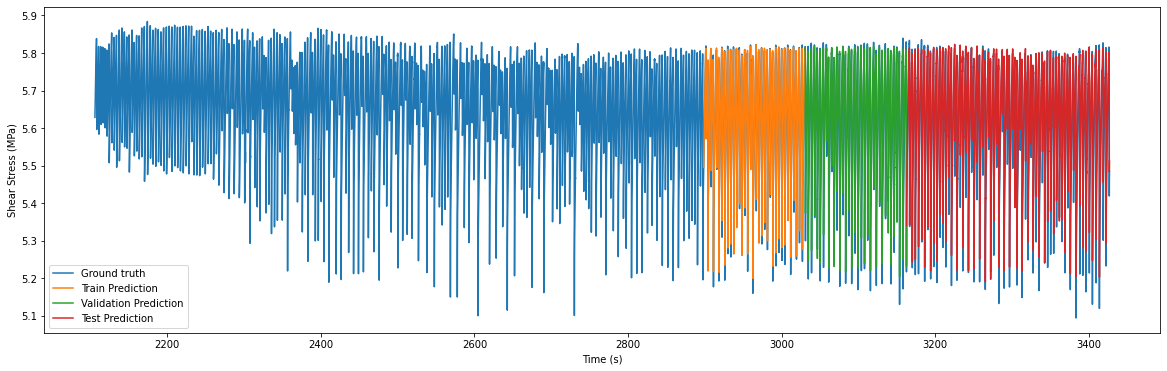

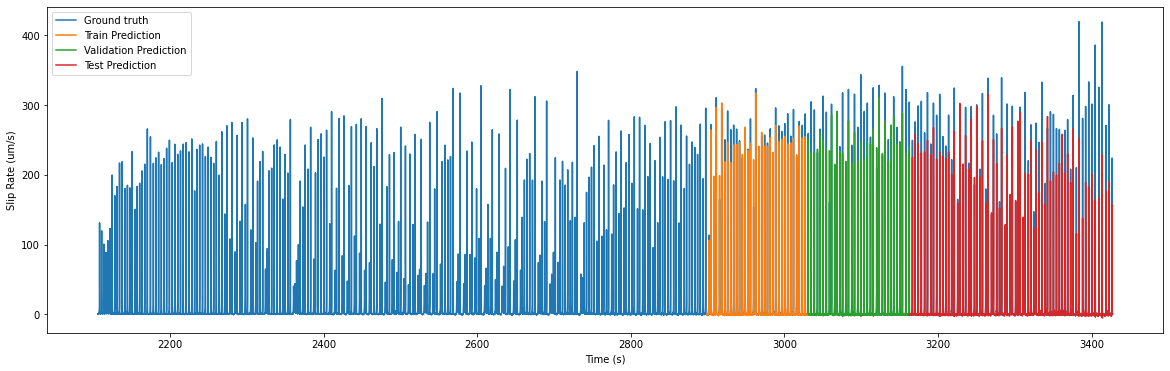

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[79259:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

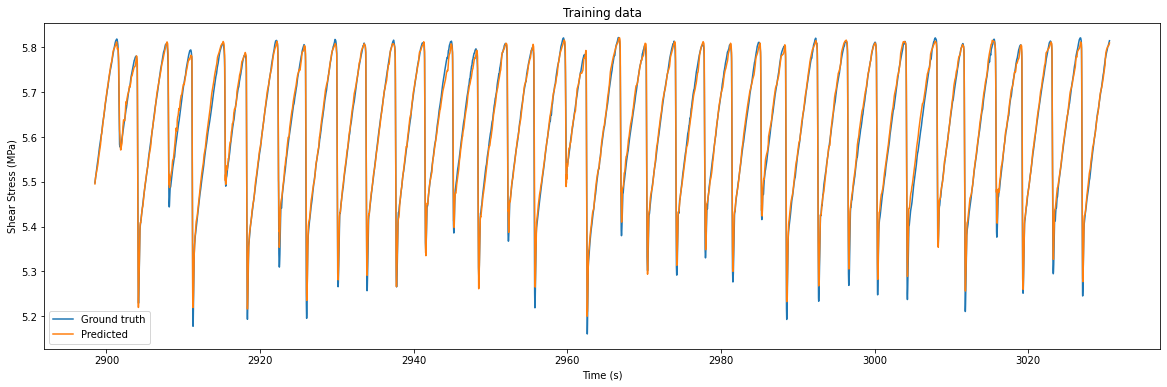

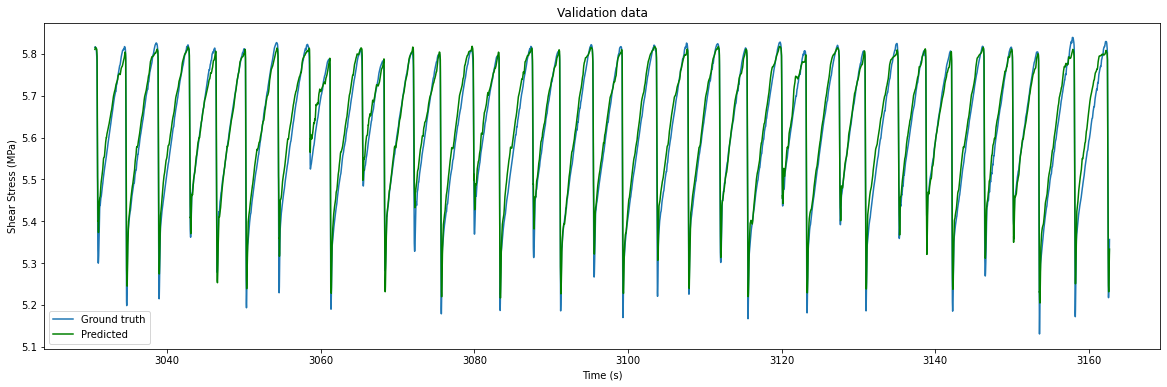

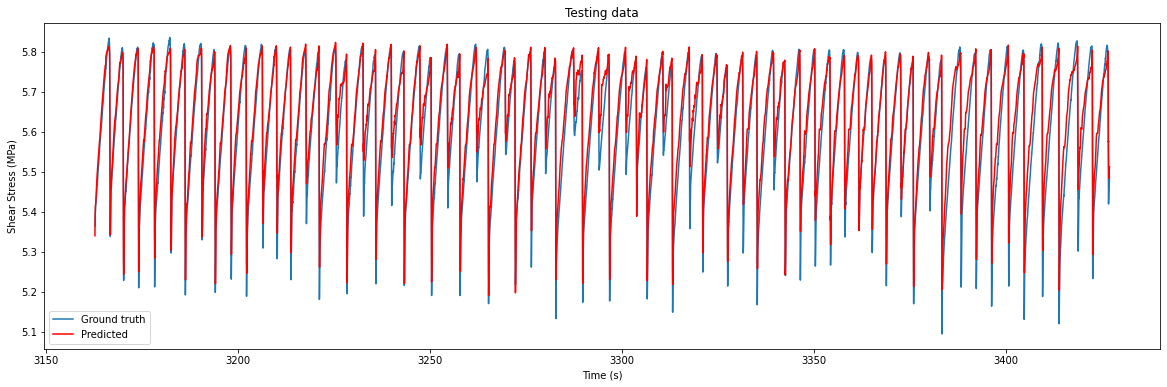

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

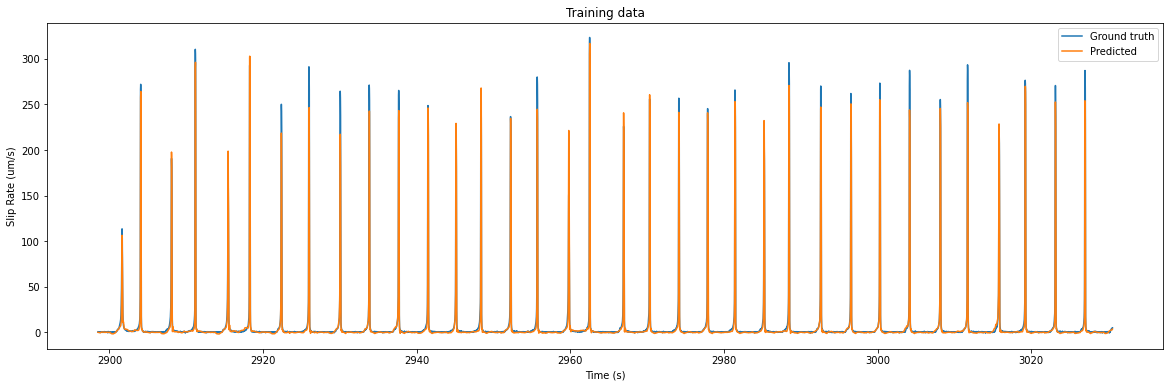

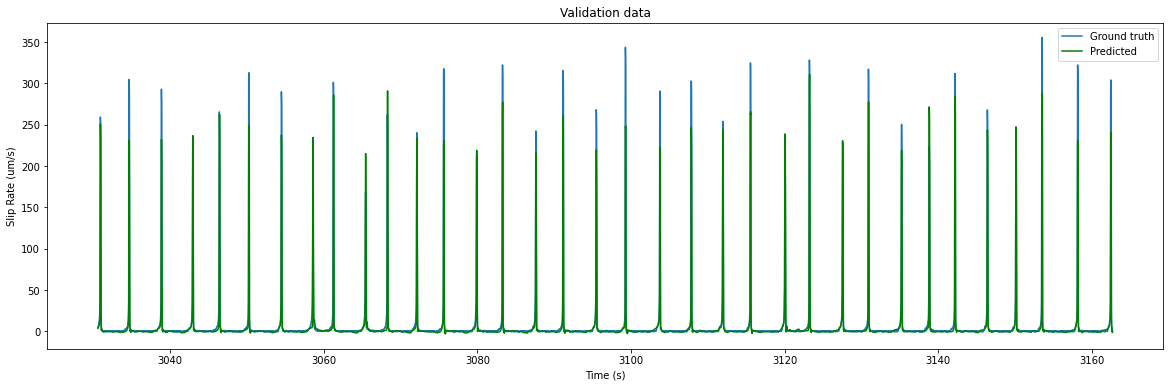

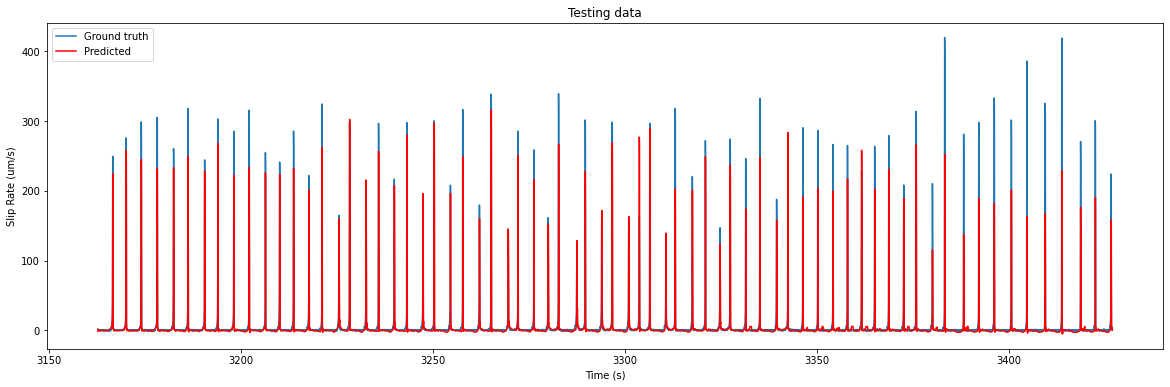

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')